## Compute kernel-derived TOA and SFC feedbacks using Huang and Huang kernels
This is a modified version of the notebook **Zelinka_TOA _SFC_feedbacks2.ipynb** 

Here we are calculating feedbacks using monthly-resolved annual cycle and monthly resolved anomalies from first 150 years of a piControl simulation. The result is not normalized by global mean temperature (i.e. result is now in units Wm^-2 instead of Wm^-2K^-1).

Modifications:

- Previously: DATA[var] contained two datasets DATA[var][0] = (time: 12, lat, lon, plev) representing climatology in first 20 years of 4xC02 and DATA[var][1] representing climatology in last 20 years of 4xC02.

- Previously: DELTA[var] = (DATA[var][1] - DATA[var][0])/GLOBAL_MEAN_TEMP

- Now, DATA[var] contains two datasets DATA[var][0] = (time: 150*12, lat, lon, plev) representing monthly resolved raw data and DATA[var][1] representing the 12 month climatology tiled 150 times. Tiling makes the time dimension 150*12 so that DELTA (anomalies) can still be calculated as 
DELTA[var] = DATA[var][1] - DATA[var][0]

- Note, we also had to tile TOA_KERN and SFC_KERN so that time dimensions are 150*12 and they can be used in calculations with DATA and DELTA. Broadcasting in xarray is not smart enough to figure this out itself.

- Only other modifications included comments, warning suppression, and a bit of logging. 

In [1]:
import xsearch as xs
import xcdat as xc
import xarray as xr
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from tqdm import tqdm
import gc 

plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 12
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.handletextpad'] = 0.4

In [2]:
import json
with open('/home/zelinka1/scripts/coast.json') as json_file:
    data = json.load(json_file)
    coastlat = data['lat']
    coastlon = data['lon360']

## Define useful functions

In [3]:
def add_to_dataset(DATA,name):
    # DS = xr.Dataset({name:(('time','lat','lon'),DATA.data)},
    # coords={'time': TIME,'lat': LAT,'lon': LON}) 
    DS = xr.Dataset({name:(('time','lat','lon'), DATA.data)}) # ZIE (drop coords)
    DS.lat.attrs['axis'] = 'Y'
    DS.lon.attrs['axis'] = 'X'
    DS2 = DS.bounds.add_missing_bounds()
    return DS2

In [4]:
def find_nearest(array, value):
#     Find the index of the item in the array nearest to the value
#     Args:
#         array: array
#         value: value be found
#     Returns:
#         int: index of value in array
#         https://tropd.github.io/pytropd/helper.html#functions.find_nearest

    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [5]:
def TropD_Calculate_TropopauseHeight(t, p, Z=None):
#     Calculate the Tropopause Height in isobaric coordinates 
#         Based on the method described in Birner (2010), according to the WMO definition: first level at which the lapse rate <= 2K/km and for which the lapse rate <= 2K/km in all levels at least 2km above the found level 
#         Args:
#             T: Temperature array of dimensions (latitude, levels) on (longitude, latitude, levels)
#             P: pressure levels in hPa
#             Z (optional): geopotential height [m] or any field with the same dimensions as T
#         Returns:
#         ndarray or tuple: 
#           If Z = None, returns Pt(lat) or Pt(lon,lat), the tropopause level in hPa 
#           If Z is given, returns Pt and Ht with shape (lat) or (lon,lat). The field Z evaluated at the tropopause. For Z=geopotential height, Ht is the tropopause altitude in m 

#     Taken from https://tropd.github.io/pytropd/_modules/functions.html#TropD_Calculate_TropopauseHeight
#     Modified by M. Zelinka

    T = np.array(t)
    P = np.array(p)
    
    import scipy as sp
    Rd = 287.04
    Cpd = 1005.7
    g = 9.80616
    k = Rd/Cpd
    PI = (np.linspace(1000,1,1000)*100)**k
    Factor = g/Cpd * 1000

    if len(np.shape(T)) == 2:
        T = np.expand_dims(T, axis=0)
        Z = np.expand_dims(Z, axis=0)
    # make P monotonically decreasing
    if P[-1] > P[0]:
        P = np.flip(P,0)
        T = np.flip(T,2)
        if Z.any():
            Z = np.flip(Z,2)

    Pk = np.tile((P*100)**k, (np.shape(T)[0], np.shape(T)[1], 1))
    Pk2 = (Pk[:,:,:-1] + Pk[:,:,1:])/2

    T2 = (T[:,:,:-1] + T[:,:,1:])/2
    Pk1 = np.squeeze(Pk2[0,0,:])

    Gamma = (T[:,:,1:] - T[:,:,:-1])/(Pk[:,:,1:] - Pk[:,:,:-1]) * Pk2 / T2 * Factor
    Gamma = np.reshape(Gamma, (np.shape(Gamma)[0]*np.shape(Gamma)[1], np.shape(Gamma)[2]))

    T2 = np.reshape(T2, (np.shape(Gamma)[0], np.shape(Gamma)[1]))
    Pt = np.zeros((np.shape(T)[0]*np.shape(T)[1], 1))

    for j in range(np.shape(Gamma)[0]):
        G_f = sp.interpolate.interp1d(Pk1, Gamma[j,:], kind='linear', fill_value='extrapolate')
        G1 = G_f(PI)
        T2_f = sp.interpolate.interp1d(Pk1,T2[j,:], kind='linear', fill_value='extrapolate')
        T1 = T2_f(PI)
        idx = np.squeeze(np.where((G1 <=2) & (PI < (550*100)**k) & (PI > (75*100)**k)))
        Pidx = PI[idx] 

    #     if np.size(Pidx): # MDZ edit
        if np.size(Pidx)>1: # MDZ edit
            for c in range(len(Pidx)):
                dpk_2km =  -2000 * k * g / Rd / T1[c] * Pidx[c]
                idx2 = find_nearest(Pidx[c:], Pidx[c] + dpk_2km)

                if sum(G1[idx[c]:idx[c]+idx2+1] <= 2)-1 == idx2:
                    Pt[j]=Pidx[c]
                    break
        elif np.size(Pidx)==1: # MDZ edit
            Pt[j]=Pidx # MDZ edit
            break # MDZ edit
        else:
            Pt[j] = np.nan



    Pt = Pt ** (1 / k) / 100

    if Z:
        Zt =  np.reshape(Z, (np.shape(Z)[0]*np.shape(Z)[1], np.shape(Z)[2]))
        Ht =  np.zeros((np.shape(T)[0]*np.shape(T)[1]))

        for j in range(np.shape(Ht)[0]):
            f = sp.interpolate.interp1d(P, Zt[j,:])
            Ht[j] = f(Pt[j])

        Ht = np.reshape(Ht, (np.shape(T)[0], np.shape(T)[1]))
        Pt = np.reshape(Pt, (np.shape(T)[0], np.shape(T)[1]))
        return Pt, Ht

    else:
        Pt = np.reshape(Pt, (np.shape(T)[0], np.shape(T)[1]))
        return Pt

In [6]:
def get_troposphere(pwts,T1):
    pwts2 = np.transpose(np.tile(pwts,(len(lon),len(lat),1)),[2,0,1])
    TROP = xr.DataArray(np.zeros(T1.shape), # ZIE edit (change TIME -> T1.time)
        coords={'time': T1.time,'lev': PLEV.values,'lat': LAT,'lon': LON})
    FULL = xr.DataArray(np.zeros(T1.shape),
        coords={'time': T1.time,'lev': PLEV.values,'lat': LAT,'lon': LON})
    T1 = T1.load() # Loading data into memory speeds up calculation
    for t in tqdm(range(T1.time.size)): # ZIE edit (12 -> T1.time.size = 1800 and add tqdm) This may take a lot longer
        ZT = T1.isel(time=t).mean('lon').transpose("lat","lev")
        print(ZT.values)
        P = ZT.lev/100
        pt = TropD_Calculate_TropopauseHeight(ZT, P)
        print(pt)
        tropp = 100*np.tile(pt,(len(PLEV),len(lon),1))
        print(tropp)
        Tlev = np.transpose(np.tile(ZT.lev,(len(lon),len(lat),1)),[2,0,1])
        print(Tlev)
        TROP[t,:] = np.transpose(np.where(Tlev < tropp, 0, pwts2),[0,2,1])
        FULL[t,:] = np.transpose(pwts2,[0,2,1])

    # plt.subplots()
    # plt.pcolor(lat,PLEV,np.nanmean(np.nanmean(newdT,0),-1))
    # plt.colorbar()
    # plt.subplots()
    # plt.plot(T1,PI**(1/k))
    return(TROP,FULL)

In [7]:
def calc_norm_dq(DATA,dTAS):
    # Compute the normalized change in hus using simplified version of what I did in the past:
    q0 = DATA['hus'][0]['hus'] 
    q1 = DATA['hus'][1]['hus']
    numer=(np.log(q1)-np.log(q0))/dTAS
    T0 = DATA['ta'][0]['ta']-273
    T1 = T0+1
    # Bolton (1980) sat vapor pressure formula
    sat0 = 6.112*np.exp((17.67*T0)/(T0 + 243.5))
    sat1 = 6.112*np.exp((17.67*T1)/(T1 + 243.5))
    # Convert from vapor pressure [hPa] to mixing ratio [kg/kg]:
    p = sat0.lev/100
    r0 = 0.622*(sat0/(p-sat0))
    r1 = 0.622*(sat1/(p-sat1))
    # Convert from mixing ratio [kg/kg] to specific humidity [kg/kg]:
    qs0 = r0/(1+r0)
    qs1 = r1/(1+r1)
    denom = (np.log(qs1)-np.log(qs0))
    norm_dq = numer/denom
    return norm_dq

In [8]:
def compute_fbks(KERN,DELTA,DATA,dTAS,flag):

    FBK=xr.Dataset()
    
    norm_dq = calc_norm_dq(DATA,dTAS)
    
    #---------------------------------------------
    # Get pressure weights for the full atmosphere and for the troposphere only
    #---------------------------------------------
    TROP,FULL = get_troposphere(pwts,DATA['ta'][1]['ta']) # ZIE Edit (piControl monthly anomalies)
    print("Finished Tropopause Calculation")
    
    #---------------------------------------------
    # ALL-SKY FEEDBACKS:
    #---------------------------------------------
    FBK['alb'] = KERN['alb_all']*DELTA['alb']['alb']

    prod = KERN['wv_lw_all']*norm_dq   
    FBK['wv_lw'] = (prod*TROP).sum('lev') # sum vertically w/wts
    prod = KERN['wv_sw_all']*norm_dq
    FBK['wv_sw'] = (prod*TROP).sum('lev') # sum vertically w/wts
    FBK['wv_net'] = FBK['wv_lw'] + FBK['wv_sw'] 
    
    sfcPL_all = KERN['ts_all']*DELTA['ts']['ts']
    prod1 = (KERN['ta_all']*DELTA['ta']['ta']).transpose('lev','time','lat','lon')
    prod2 = KERN['ta_all'].transpose('lev','time','lat','lon')*DELTA['ts']['ts']
    # Mask prod1 and prod2 in same places:
    prod3 = xr.where(prod1==0,0,prod2)
    ta_all = (prod1*TROP).sum('lev') # sum vertically w/wts
    atmPL_all = (prod3*TROP).sum('lev') # sum vertically w/wts
#     FBK['PL_up'] = sfcPL_all
#     FBK['PL_dn'] = atmPL_all
    FBK['PL'] = sfcPL_all + atmPL_all
    FBK['LR'] = ta_all - atmPL_all


    # HELD AND SHELL FEEDBACKS:
    # (original water vapor kernel) x (atmospheric temperature response):
    prod = KERN['wv_lw_all']*DELTA['ta']['ta']
    HS_wv_lw_all = (prod*TROP).sum('lev') # sum vertically w/wts
    prod = KERN['wv_sw_all']*DELTA['ta']['ta']
    HS_wv_sw_all = (prod*TROP).sum('lev') # sum vertically w/wts

    # Compute \\Fixed RH\\ T kernel following Held and Shell 2012
    NET_Tkern_fxRH = KERN['ta_all'] + KERN['wv_lw_all'] + KERN['wv_sw_all']
    prod = NET_Tkern_fxRH*DELTA['ta']['ta']
    fxRH_ta_all = (prod*TROP).sum('lev') # sum vertically w/wts
    prod = NET_Tkern_fxRH.transpose('lev','time','lat','lon')*DELTA['ts']['ts']
    fx_RH_atmPL_all = (prod*TROP).sum('lev') # sum vertically w/wts
    FBK['HS_PL'] = sfcPL_all + fx_RH_atmPL_all
    FBK['HS_LR'] = fxRH_ta_all - fx_RH_atmPL_all
    # RH feedback  = traditional WV fbk minus (orig. WVkern x Ta response)
    FBK['HS_RH'] = (FBK['wv_sw'] - HS_wv_sw_all) + (FBK['wv_lw'] - HS_wv_lw_all)

    #---------------------------------------------
    # CLEAR-SKY FEEDBACKS:
    #---------------------------------------------
    FBK['alb_clr'] = KERN['alb_clr']*DELTA['alb']['alb']
    
    prod = KERN['wv_lw_clr']*norm_dq
    FBK['wv_lw_clr'] = (prod*TROP).sum('lev') # sum vertically w/wts
    prod = KERN['wv_sw_clr']*norm_dq
    FBK['wv_sw_clr'] = (prod*TROP).sum('lev') # sum vertically w/wts
    FBK['wv_net_clr'] = FBK['wv_lw_clr'] + FBK['wv_sw_clr']     
    
    sfcPL_clr = KERN['ts_clr']*DELTA['ts']['ts']
    prod1 = (KERN['ta_clr']*DELTA['ta']['ta']).transpose('lev','time','lat','lon')
    prod2 = KERN['ta_clr'].transpose('lev','time','lat','lon')*DELTA['ts']['ts']
    # Mask prod1 and prod2 in same places:
    prod3 = xr.where(prod1==0,0,prod2)
    ta_clr = (prod1*TROP).sum('lev') # sum vertically w/wts
    atmPL_clr = (prod3*TROP).sum('lev') # sum vertically w/wts
    FBK['PL_clr'] = sfcPL_clr + atmPL_clr
    FBK['LR_clr'] = ta_clr - atmPL_clr

    # HELD AND SHELL FEEDBACKS:
    # (original water vapor kernel) x (atmospheric temperature response):
    prod = KERN['wv_lw_clr']*DELTA['ta']['ta']
    HS_wv_lw_clr = (prod*TROP).sum('lev') # sum vertically w/wts
    prod = KERN['wv_sw_clr']*DELTA['ta']['ta']
    HS_wv_sw_clr = (prod*TROP).sum('lev') # sum vertically w/wts

    # Compute \\Fixed RH\\ T kernel following Held and Shell 2012
    NET_Tkern_fxRH = KERN['ta_clr'] + FBK['wv_lw_clr'] + FBK['wv_sw_clr']
    prod = NET_Tkern_fxRH*DELTA['ta']['ta']
    fxRH_ta_clr = (prod*TROP).sum('lev') # sum vertically w/wts
    prod = NET_Tkern_fxRH.transpose('lev','time','lat','lon')*DELTA['ts']['ts']
    fx_RH_atmPL_clr = (prod*TROP).sum('lev') # sum vertically w/wts
    FBK['HS_PL_clr'] = sfcPL_clr + fx_RH_atmPL_clr
    FBK['HS_LR_clr'] = fxRH_ta_clr - fx_RH_atmPL_clr
    # RH feedback  = traditional WV fbk minus (orig. WVkern x Ta response)
    FBK['HS_RH_clr'] = (FBK['wv_sw_clr'] - HS_wv_sw_clr) + (FBK['wv_lw_clr'] - HS_wv_lw_clr)

    #---------------------------------------------
    # CLOUD FEEDBACKS:
    #---------------------------------------------
    # Cloud masking terms (these should be troposphere only)
    LW_Planck_mask = FBK['PL_clr'] - FBK['PL']
    LW_LR_mask = FBK['LR_clr'] - FBK['LR']
    LW_WV_mask = FBK['wv_lw_clr'] - FBK['wv_lw']
    SW_alb_mask = FBK['alb_clr'] - FBK['alb']
    SW_WV_mask = FBK['wv_sw_clr'] - FBK['wv_sw']

    # total corrections necessary to adjust the delta CRE into cloud feedback:
    LW_sum_correct = LW_Planck_mask + LW_LR_mask + LW_WV_mask
    SW_sum_correct = SW_WV_mask + SW_alb_mask
    NET_sum_correct = LW_sum_correct + SW_sum_correct
    
    if flag=='toa':
        FBK['cld_lw'] = DELTA['LWCRE']['LWCRE'] + LW_sum_correct
        FBK['cld_sw'] = DELTA['SWCRE']['SWCRE'] + SW_sum_correct
        FBK['cld_net'] = DELTA['netCRE']['netCRE'] + NET_sum_correct
        FBK['LWtrue'] = -DELTA['rlut']['rlut']
        FBK['SWtrue'] = DELTA['rsdt']['rsdt'] - DELTA['rsut']['rsut']
        FBK['NETtrue'] = DELTA['rndt']['rndt']
        FBK['LWtrue_clr'] = -DELTA['rlutcs']['rlutcs']
        FBK['SWtrue_clr'] = DELTA['rsdt']['rsdt'] - DELTA['rsutcs']['rsutcs']
        FBK['NETtrue_clr'] = DELTA['rndtcs']['rndtcs']   
    else:
        FBK['cld_lw'] = DELTA['sfc_LWCRE']['sfc_LWCRE'] + LW_sum_correct
        FBK['cld_sw'] = DELTA['sfc_SWCRE']['sfc_SWCRE'] + SW_sum_correct
        FBK['cld_net'] = DELTA['sfc_netCRE']['sfc_netCRE'] + NET_sum_correct
        FBK['LWtrue'] = DELTA['rlds']['rlds'] - DELTA['rlus']['rlus']
        FBK['SWtrue'] = DELTA['rsds']['rsds'] - DELTA['rsus']['rsus']
        FBK['NETtrue'] = DELTA['rnds']['rnds']
        FBK['LWtrue_clr'] = DELTA['rldscs']['rldscs'] - DELTA['rlus']['rlus']
        FBK['SWtrue_clr'] = DELTA['rsdscs']['rsdscs'] - DELTA['rsuscs']['rsuscs']
        FBK['NETtrue_clr'] = DELTA['rndscs']['rndscs']
   
    #---------------------------------------------
    # SUMMATION OF FEEDBACKS:
    #---------------------------------------------
#     FBK['sum_lw_dn'] = FBK['PL_dn'] + FBK['LR'] + FBK['wv_lw'] + FBK['cld_lw']
#     FBK['sum_lw_up'] = FBK['PL_up']
    FBK['sum_lw'] = FBK['PL'] + FBK['LR'] + FBK['wv_lw'] + FBK['cld_lw']
    FBK['sum_sw'] = FBK['wv_sw'] + FBK['alb'] + FBK['cld_sw']
    FBK['sum_net'] = FBK['sum_lw'] + FBK['sum_sw']
    FBK['resid_lw'] = FBK['LWtrue'] - FBK['sum_lw']
    FBK['resid_sw'] = FBK['SWtrue'] - FBK['sum_sw']
    FBK['resid_net'] = FBK['NETtrue'] - FBK['sum_net']
    
    FBK['sum_lw_clr'] = FBK['PL_clr'] + FBK['LR_clr'] + FBK['wv_lw_clr']
    FBK['sum_sw_clr'] = FBK['wv_sw_clr'] + FBK['alb_clr']
    FBK['sum_net_clr'] = FBK['sum_lw_clr'] + FBK['sum_sw_clr']
    FBK['resid_lw_clr'] = FBK['LWtrue_clr'] - FBK['sum_lw_clr']
    FBK['resid_sw_clr'] = FBK['SWtrue_clr'] - FBK['sum_sw_clr']
    FBK['resid_net_clr'] = FBK['NETtrue_clr'] - FBK['sum_net_clr']

    FBK.lat.attrs['axis'] = 'Y'
    FBK.lon.attrs['axis'] = 'X'
    FBK = FBK.bounds.add_missing_bounds()    
    FBK['lat_bnds'] = Ybnds
    FBK['lon_bnds'] = Xbnds
    
    
    return(FBK)
    


In [9]:
def clr_sky_linearity(FBK,flag):
    # CLEAR-SKY LINEARITY TEST   

    plt.subplots()   
    var='LWtrue_clr'
    GL = np.round(FBK.spatial.average(var)[var].mean('time').values,2)
    plt.plot(lat,FBK[var].mean(('time','lon')),label=var+' ['+str(GL)+']',color='C1',ls='--')
    var='SWtrue_clr'
    GL = np.round(FBK.spatial.average(var)[var].mean('time').values,2)
    plt.plot(lat,FBK[var].mean(('time','lon')),label=var+' ['+str(GL)+']',color='C2',ls='--')
    var='NETtrue_clr'
    GL = np.round(FBK.spatial.average(var)[var].mean('time').values,2)
    plt.plot(lat,FBK[var].mean(('time','lon')),label=var+' ['+str(GL)+']',color='C0',ls='--')

    var='sum_lw_clr'
    GL = np.round(FBK.spatial.average(var)[var].mean('time').values,2)
    plt.plot(lat,FBK[var].mean(('time','lon')),label=var+' ['+str(GL)+']',color='C1',ls='-')
    var='sum_sw_clr'
    GL = np.round(FBK.spatial.average(var)[var].mean('time').values,2)
    plt.plot(lat,FBK[var].mean(('time','lon')),label=var+' ['+str(GL)+']',color='C2',ls='-')
    var='sum_net_clr'
    GL = np.round(FBK.spatial.average(var)[var].mean('time').values,2)
    plt.plot(lat,FBK[var].mean(('time','lon')),label=var+' ['+str(GL)+']',color='C0',ls='-')

    plt.legend(ncol=2)
    plt.axhline(y=0,color='k')
    plt.title(modripf+' ['+flag+']',loc='left')
    # plt.savefig('/home/zelinka1/figures/'+era+'/feedbacks/'+exp+'/clrsky_linearity_'+modripf+'_'+flag+'.png')
    
    


## Read in Huang and Huang kernels and place into a dataset

/home/espinosa10/.conda/envs/cloudmask/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/espinosa10/.conda/envs/cloudmask/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/espinosa10/.conda/envs/cloudmask/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/espinosa10/.conda/envs/cloudmask/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/espinosa10/.conda/envs/cloudmask/lib/python3.1

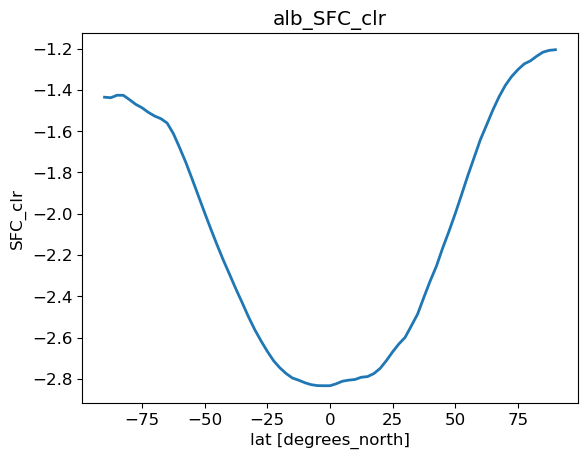

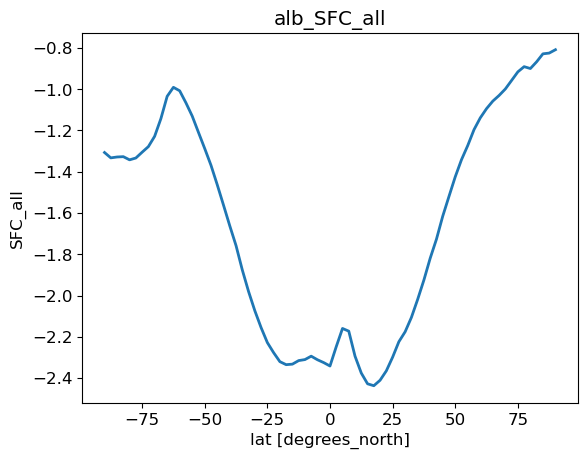

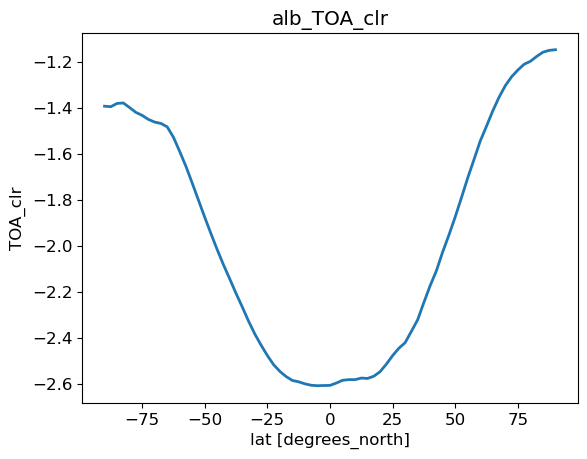

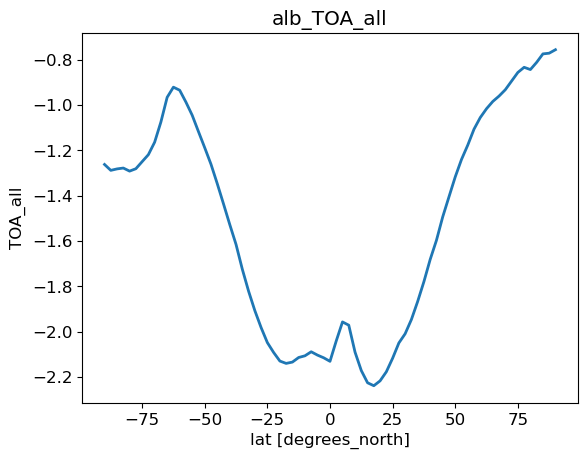

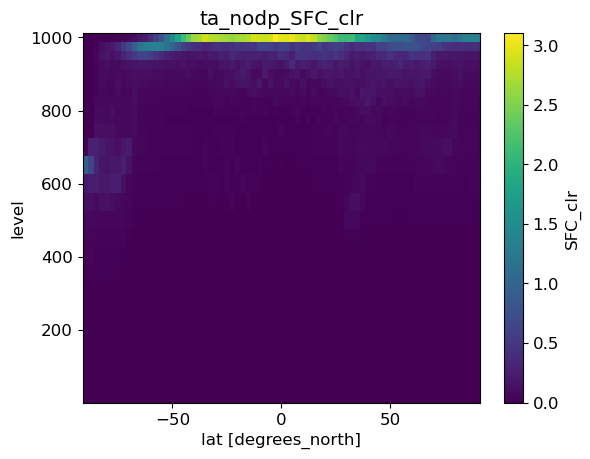

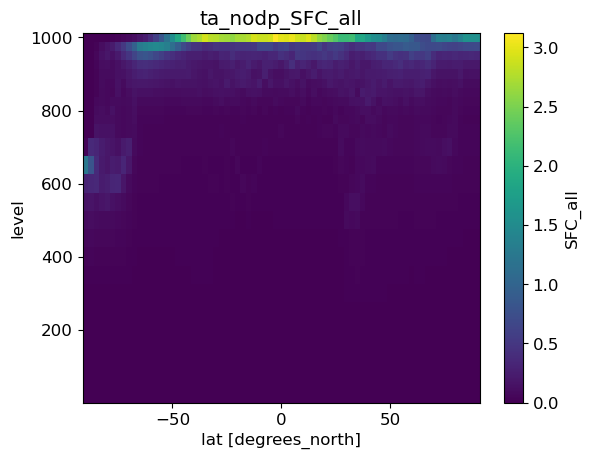

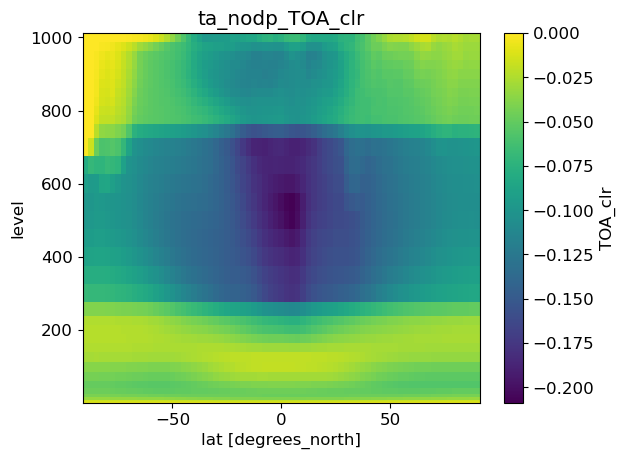

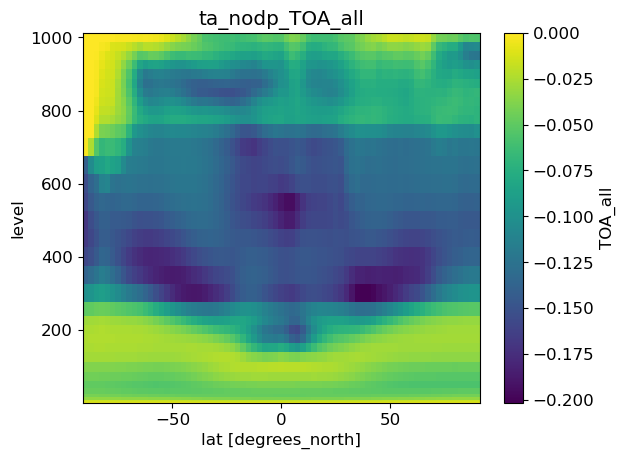

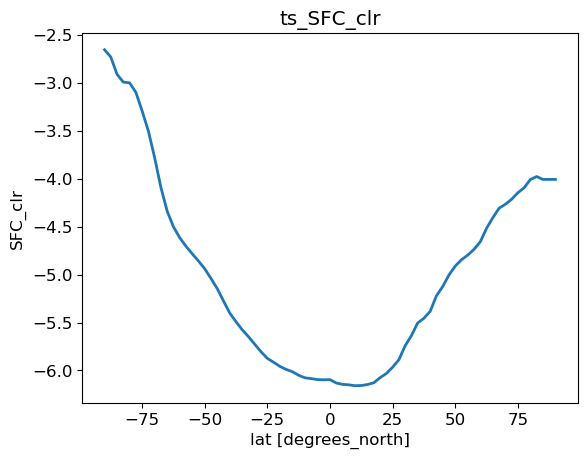

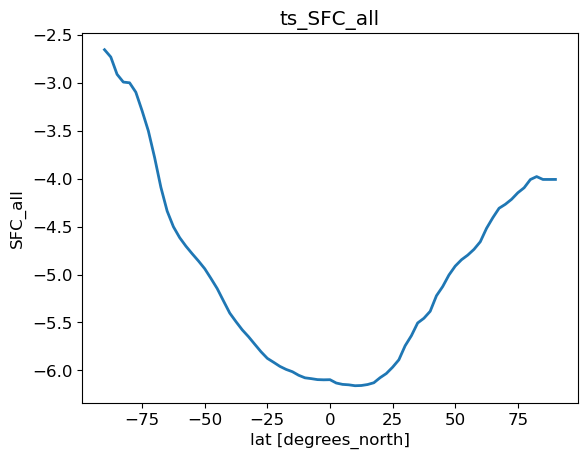

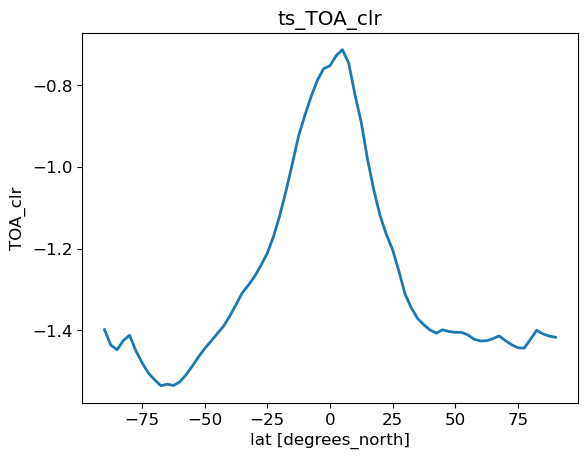

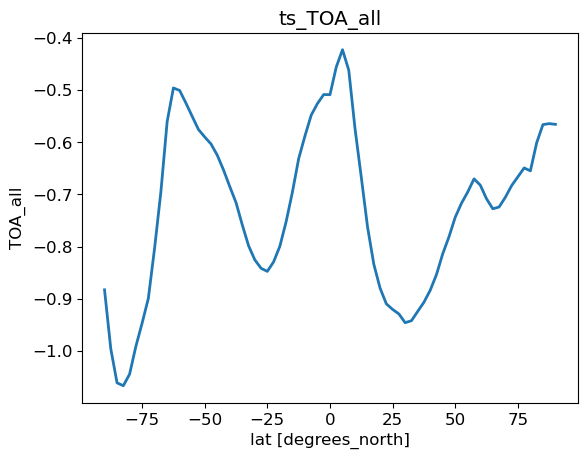

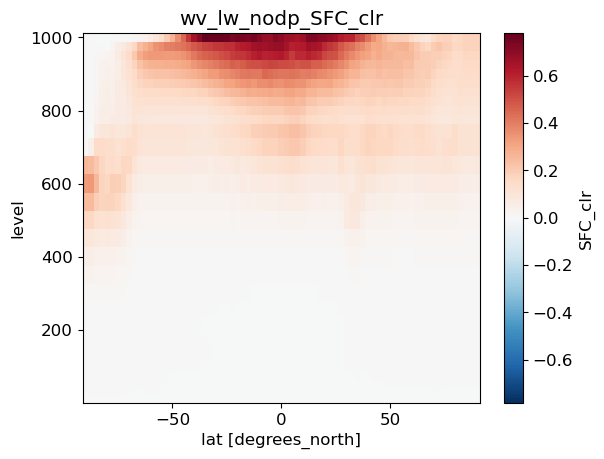

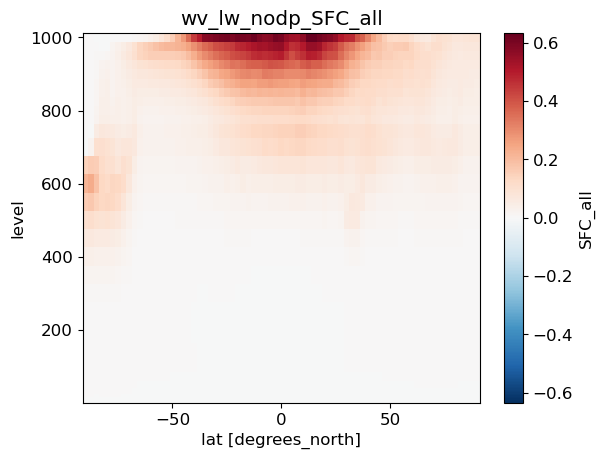

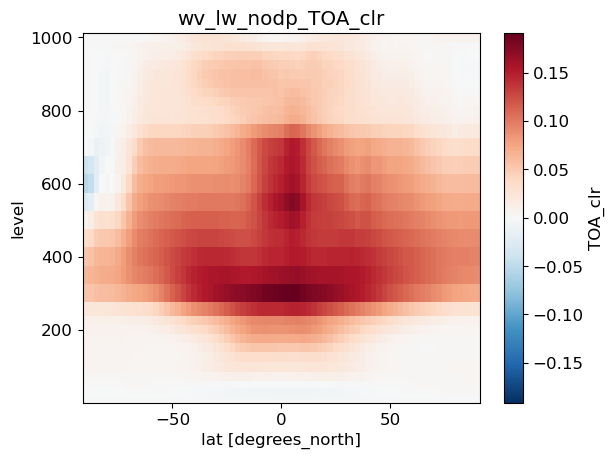

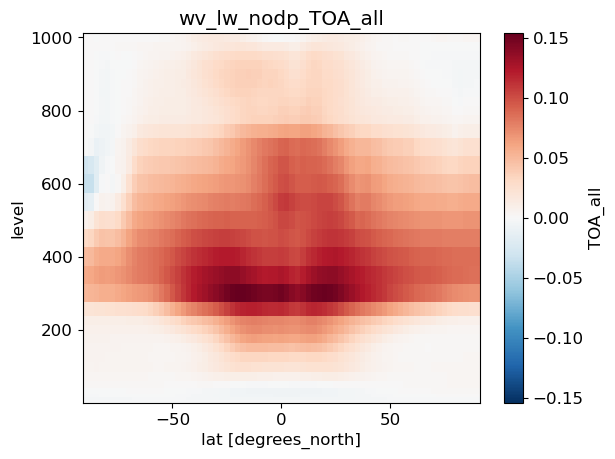

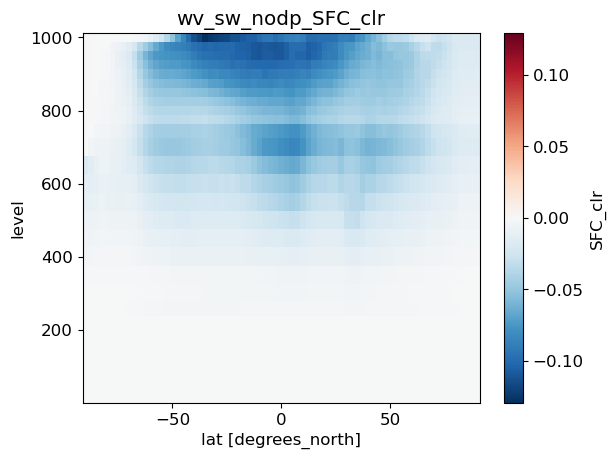

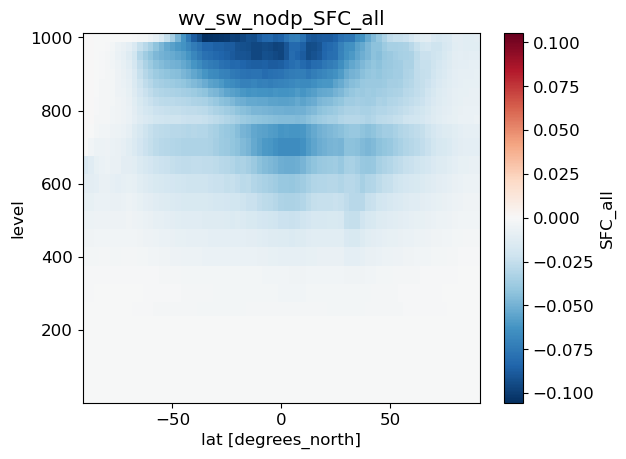

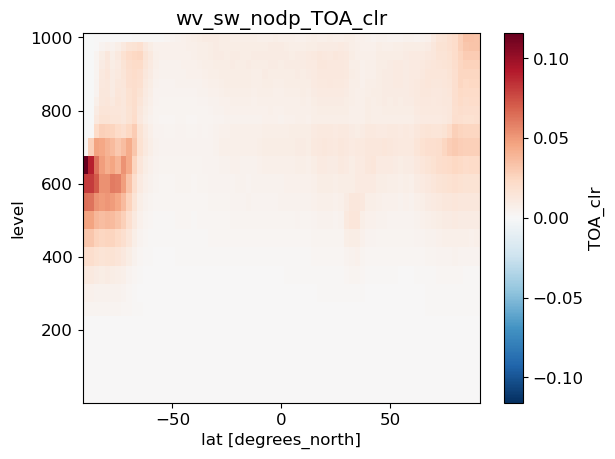

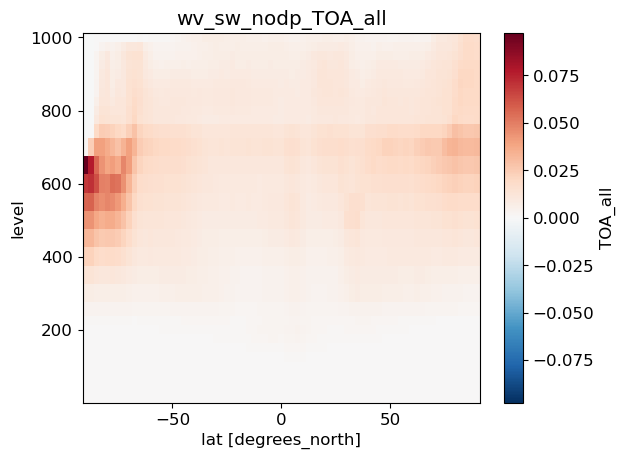

In [10]:
# Huang kernel grid:
kern=xc.open_dataset('/home/zelinka1/kernels/huang/era5/nodp/ERA5_kernel_ta_nodp_SFC.nc',decode_times=False)
kern = kern.sortby('latitude', ascending=True)  # -90 to 90
lat = np.array(kern.latitude)
lon = np.array(kern.longitude)
lat_a = xc.create_axis("lat", lat)
lon_a = xc.create_axis("lon", lon)
output_grid = xc.regridder.grid.create_grid(y=lat_a, x=lon_a)
                  
K={}
gg = glob.glob('/home/zelinka1/kernels/huang/era5/nodp/ERA5_kernel_*.nc')
gg.sort()
for g in gg:
    kern=xc.open_dataset(g,decode_times=False)
    kern = kern.sortby('latitude', ascending=True)  # -90 to 90
    this = kern.rename({'month': 'time','latitude': 'lat','longitude': 'lon'})
    for var in kern.data_vars:
        if 'bnds' in var:
            continue
        plt.subplots()
        this[var].mean(('time','lon')).plot()
        name = g.split('/')[-1].split('kernel_')[-1].split('.')[0]+'_'+var.split('_')[-1]
        plt.title(name)
        
        # Regrid to kernel grid:
        output = this.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear')

        K[name] = output#kern[var]
        
# Convert these back into an xarray dataset:
TIME = K['ta_nodp_TOA_all'].time
PLEV = 100*K['ta_nodp_TOA_all'].level
LAT = K['ta_nodp_TOA_all'].lat
LON = K['ta_nodp_TOA_all'].lon

# TOA KERNEL:
DS = xr.Dataset(
{
    'wv_lw_all':(('time','lev','lat','lon'),K['wv_lw_nodp_TOA_all']['TOA_all'].data),
    'wv_lw_clr':(('time','lev','lat','lon'),K['wv_lw_nodp_TOA_clr']['TOA_clr'].data),   
    'wv_sw_all':(('time','lev','lat','lon'),K['wv_sw_nodp_TOA_all']['TOA_all'].data),
    'wv_sw_clr':(('time','lev','lat','lon'),K['wv_sw_nodp_TOA_clr']['TOA_clr'].data),
   
    'ta_all':(('time','lev','lat','lon'),K['ta_nodp_TOA_all']['TOA_all'].data),
    'ta_clr':(('time','lev','lat','lon'),K['ta_nodp_TOA_clr']['TOA_clr'].data),
    'alb_all':(('time','lat','lon'),K['alb_TOA_all']['TOA_all'].data),
    'alb_clr':(('time','lat','lon'),K['alb_TOA_clr']['TOA_clr'].data),
    'ts_all':(('time','lat','lon'),K['ts_TOA_all']['TOA_all'].data),    
    'ts_clr':(('time','lat','lon'),K['ts_TOA_clr']['TOA_clr'].data),
},
coords={'time': TIME,'lev': PLEV.values,'lat': LAT,'lon': LON},
) 
DS.lat.attrs['axis'] = 'Y'
DS.lon.attrs['axis'] = 'X'
TOA_KERN = DS.bounds.add_missing_bounds()

# SFC KERNEL:
DS = xr.Dataset(
{
    'wv_lw_all':(('time','lev','lat','lon'),K['wv_lw_nodp_SFC_all']['SFC_all'].data),
    'wv_lw_clr':(('time','lev','lat','lon'),K['wv_lw_nodp_SFC_clr']['SFC_clr'].data),
    'wv_sw_all':(('time','lev','lat','lon'),K['wv_sw_nodp_SFC_all']['SFC_all'].data),
    'wv_sw_clr':(('time','lev','lat','lon'),K['wv_sw_nodp_SFC_clr']['SFC_clr'].data),
    'ta_all':(('time','lev','lat','lon'),K['ta_nodp_SFC_all']['SFC_all'].data),
    'ta_clr':(('time','lev','lat','lon'),K['ta_nodp_SFC_clr']['SFC_clr'].data),   
    'alb_all':(('time','lat','lon'),K['alb_SFC_all']['SFC_all'].data),
    'alb_clr':(('time','lat','lon'),K['alb_SFC_clr']['SFC_clr'].data),
    'ts_all':(('time','lat','lon'),K['ts_SFC_all']['SFC_all'].data),
    'ts_clr':(('time','lat','lon'),K['ts_SFC_clr']['SFC_clr'].data),    
},
coords={'time': TIME,'lev': PLEV.values,'lat': LAT,'lon': LON},
) 
DS.lat.attrs['axis'] = 'Y'
DS.lon.attrs['axis'] = 'X'
SFC_KERN = DS.bounds.add_missing_bounds()

In [11]:
# lay_thick = np.gradient(np.array(TOA_KERN.lev)) # typically 2500 Pa = 25 hPa
# pwts = -lay_thick/100/100 # convert from Pa to hPa, then to per 100 hPa
# pwts,lay_thick,KERN.lev
pwts=np.ones(len(TOA_KERN.lev))

In [12]:
# plt.figure(figsize=(10,8))
# plt.suptitle('Vertically-integrated SFC ta kernel',y=0.95)


# plt.subplot(221)
# THAT = (SFC_KERN['ta_clr']*FULL).sum('lev')
# plt.contourf(lon,lat,THAT.mean('time'),np.arange(-6,6.5,0.5),cmap='RdBu_r',extend='both')
# plt.colorbar()
# plt.plot(coastlon, coastlat, color = 'k', linewidth = 0.5)
# plt.xticks([])
# plt.yticks([])
# plt.xlim(0, 360)
# plt.title('Clr-sky',loc='left')

# plt.subplot(222)
# plt.plot(lat,THAT.mean(('time','lon')))
# plt.title('Zonal Mean (clr-sky)',loc='left')
# plt.ylim(1,6)

# plt.subplot(223)
# THIS = (SFC_KERN['ta_all']*FULL).sum('lev')
# plt.contourf(lon,lat,THIS.mean('time'),np.arange(-6,6.5,0.5),cmap='RdBu_r',extend='both')
# plt.colorbar()
# plt.plot(coastlon, coastlat, color = 'k', linewidth = 0.5)
# plt.xticks([])
# plt.yticks([])
# plt.xlim(0, 360)
# plt.title('All-sky',loc='left')

# plt.subplot(224)
# plt.plot(lat,THIS.mean(('time','lon')))
# plt.title('Zonal Mean (all-sky)',loc='left')
# plt.ylim(1,6)




In [13]:
# plt.figure(figsize=(10,8))
# plt.subplot(221)
# plt.contourf(lon,lat,SFC_KERN['ts_all'].mean('time'),np.arange(-8,8.5,0.5),cmap='RdBu_r',extend='both')
# plt.colorbar()
# plt.plot(coastlon, coastlat, color = 'k', linewidth = 0.5)
# plt.xticks([])
# plt.yticks([])
# plt.xlim(0, 360)
# plt.title('SFC ts kernel (all sky)',loc='left')

# plt.subplot(222)
# plt.plot(lat,SFC_KERN['ts_all'].mean(('time','lon')),label='all-sky')
# plt.plot(lat,SFC_KERN['ts_clr'].mean(('time','lon')),ls='--',label='clr-sky')
# plt.legend()
# plt.title('Zonal Mean SFC ts kernel',loc='left')
# plt.ylim(-7,-2)

# # prod3.isel(lev=slice(None,3)).mean('time').plot(col='lev',col_wrap=3)
# plt.figure(figsize=(10,6))
# plt.subplot(221)
# THIS = SFC_KERN['ta_all']*FULL
# THIS.sum('lev').mean(('time','lon')).plot(label='all-sky')
# THIS = SFC_KERN['ta_clr']*FULL
# THIS.sum('lev').mean(('time','lon')).plot(label='clr-sky')
# plt.legend()
# plt.title('ta SFC kernel')

# plt.subplot(222)
# THIS = (SFC_KERN['ta_all']*FULL).sum('lev')
# THAT = SFC_KERN['ts_all']
# (THIS+THAT).mean(('time','lon')).plot(label='all-sky')
# THIS = (SFC_KERN['ta_clr']*FULL).sum('lev')
# THAT = SFC_KERN['ts_clr']
# (THIS+THAT).mean(('time','lon')).plot(label='clr-sky')
# plt.legend()
# plt.title('ta + ts SFC kernel'

## Search for all available models with the necessary output

In [14]:
variables = ['tas','huss','rlut','rlutcs','rsds','rsdt','rsus','rsut','rsutcs','ts',
             'hus','ta','rsdscs','rsuscs','rlds','rldscs','rlus','pr','hfls','hfss']
# variables = ['tas','rsds','rsus', 'ta', 'hus', 'huss'] # ZIE Edit (For Testing)

eras = ['CMIP5','CMIP6'] # user choice
everything={}
keep={}
for era in eras:
    modripfs=[]
    everything[era]={}
    if era=='CMIP5':
        exps = ['piControl'] # ZIE edit (abrupt-4xCO2 -> piControl)
        ACT = '*'
    else:
        exps = ['piControl'] # ZIE edit (abrupt-4xCO2 -> piControl)
        ACT = '*'
    for exp in exps:
        everything[era][exp]={}
        for var in variables:
            everything[era][exp][var]={}
            pathDict = xs.findPaths(exp, var, 'mon', mip_era=era, cmipTable='*mon', activity=ACT)#, filterRetracted=False)
            models = xs.getGroupValues(pathDict, 'model')
            for mod in models:
                
                everything[era][exp][var][mod]={}
                pathDict = xs.findPaths(exp, var, 'mon', mip_era=era, cmipTable='*mon', activity=ACT, model=mod)#, filterRetracted=False)
                ripfs = xs.getGroupValues(pathDict, 'member')
                for ripf in ripfs:
                    pathDict = xs.findPaths(exp, var, 'mon', mip_era=era, cmipTable='*mon',activity=ACT, model=mod, member=ripf)#, filterRetracted=False)
                    dpath=list(pathDict.keys())
                    if len(dpath)==1:
                        everything[era][exp][var][mod+'.'+ripf] = dpath[0]
                        modripfs.append(mod+'.'+ripf)
                    else:
                        break # need to investigate why more than one path survived...

    # Need to find which models.ripfs have all variables for both experiments:
    keep[era]=[]
    modripfs.sort()
    for modripf in np.unique(modripfs):
#         if 'r1i' not in modripf:
#             continue
        names=[]
        for var in variables:
            for exp in exps:
                try:
                    names.append((everything[era][exp][var][modripf]))
                except:
                    print('No '+var+' data for '+modripf+'.'+exp)
                    continue
        if len(names) == len(variables) * len(exps):
            keep[era].append(modripf)

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consider filtering by realm.
Available values: atmos, ocean

Multiple values for realm. Consi

In [15]:
# print(len(keep['CMIP6']), keep['CMIP6'])
'CESM2.r1i1p1f1' in keep['CMIP6']
print(len(keep['CMIP5']), keep['CMIP5'])

40 ['ACCESS1-0.r1i1p1', 'ACCESS1-3.r1i1p1', 'BNU-ESM.r1i1p1', 'CCSM4.r1i1p1', 'CCSM4.r2i1p1', 'CCSM4.r3i1p1', 'CESM1-BGC.r1i1p1', 'CESM1-FASTCHEM.r1i1p1', 'CESM1-WACCM.r1i1p1', 'CNRM-CM5-2.r1i1p1', 'CNRM-CM5-2.r1i1p2', 'CNRM-CM5-2.r1i1p3', 'CNRM-CM5-2.r1i1p4', 'CNRM-CM5.r1i1p1', 'CanESM2.r1i1p1', 'FGOALS-s2.r1i1p1', 'GFDL-CM3.r1i1p1', 'GFDL-ESM2G.r1i1p1', 'GFDL-ESM2M.r1i1p1', 'GISS-E2-H-CC.r1i1p1', 'GISS-E2-H.r1i1p1', 'GISS-E2-R-CC.r1i1p1', 'GISS-E2-R.r1i1p1', 'GISS-E2-R.r1i1p141', 'GISS-E2-R.r1i1p142', 'HadGEM2-CC.r1i1p1', 'HadGEM2-ES.r1i1p1', 'IPSL-CM5A-LR.r1i1p1', 'IPSL-CM5A-MR.r1i1p1', 'IPSL-CM5B-LR.r1i1p1', 'MIROC-ESM-CHEM.r1i1p1', 'MIROC-ESM.r1i1p1', 'MIROC4h.r1i1p1', 'MIROC5.r1i1p1', 'MRI-CGCM3.r1i1p1', 'NorESM1-M.r1i1p1', 'NorESM1-ME.r1i1p1', 'bcc-csm1-1-m.r1i1p1', 'bcc-csm1-1.r1i1p1', 'inmcm4.r1i1p1']


In [16]:
# Huang kernel grid:
kern=xc.open_dataset('/home/zelinka1/kernels/huang/era5/nodp/ERA5_kernel_ta_nodp_SFC.nc',decode_times=False)
kern = kern.sortby('latitude', ascending=True)  # -90 to 90
kern
eras = ['CMIP5', 'CMIP6']
z = xc.create_axis('lev', np.array(PLEV))
want = xc.create_grid(z=z)
want

<xarray.Dataset> Size: 444B
Dimensions:   (lev: 37, bnds: 2)
Coordinates:
  * lev       (lev) float32 148B 1e+05 9.75e+04 9.5e+04 ... 300.0 200.0 100.0
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float32 296B 1.012e+05 9.875e+04 ... 150.0 50.0

## Loop over all models/variants and do kernel calculations

In [17]:
# import warnings
import pickle
import os
# warnings.simplefilter("ignore") # Bad Practice but lets suppress xarray warnings for now. 

In [18]:
# fpath = '/home/espinosa10/tropical_pacific_clouds/cloud_masking/cmip6' # ZIE edit
# modripf = 'CESM2.r1i1p1f1' # ZIE edit (temporary to test one model)
# DATA_FILE = f'{fpath}/{modripf}-DATA.pkl'
# if os.path.exists(DATA_FILE):
#     DATA = pickle.load(open(DATA_FILE, 'rb'))
# DATA

In [19]:
# DATA['ta'][1]['ta'] = DATA['ta'][1]['ta'].load()
# DATA['ta'][1]['ta'][:,:15,:] = xr.where(np.isnan(DATA['ta'][1]['ta'][:,:15,:]),
#                                 DATA['tas'][1]['tas'],
#                                 DATA['ta'][1]['ta'][:,:15,:])

# TROP,FULL = get_troposphere(pwts, DATA['ta'][1]['ta']) # ZIE Edit (piControl climatology)

In [20]:
for era in eras:
    if era=='CMIP5':
        exp = 'piControl' # ZIE edit
        fpath = '/home/espinosa10/tropical_pacific_clouds/cloud_masking/cmip5' # ZIE edit
#         continue
    else:
        exp = 'piControl' # ZIE edit
        fpath = '/home/espinosa10/tropical_pacific_clouds/cloud_masking/cmip6' # ZIE edit

    for modripf in sorted(keep[era]):
        try: 
            # if os.path.exists(fpath+'/sfc_fbks_'+modripf+'.nc'):
                # continue
            if modripf=='CAS-ESM2-0.r1i1p1f1':
                continue # two files contain year 50
            if modripf=='ICON-ESM-LR.r1i1p1f1':
                continue # do not use
            if modripf=='GISS-E2-1-G.r1i1p1f3':
                continue # minimal warming --- maybe does not start at time of quadrupling?
                
    #         gg=glob.glob(fpath+'bonan_'+modripf+'.nc')
    #         if len(gg)>0:
    #             print('Already saved data from '+modripf+'; continuing...')
    #             continue

            t0 = time.time() 
            mod,ripf = modripf.split('.')

            if ripf != 'r1i1p1': continue

            skip=False   
            DATA_FILE = f'{fpath}/{modripf}-DATA.pkl'
            if os.path.exists(DATA_FILE):
                DATA = pickle.load(open(DATA_FILE, 'rb'))
            else:
                DATA={} 
                for var in variables:   
                    DATA[var]={}         
                    pathDict = xs.findPaths(exp, var, 'mon', mip_era=era, realm='atmos',cmipTable='Amon', model=mod, member=ripf)
                    dpath=list(pathDict.keys())
                    filename = dpath[0] 
                    if var=='tas':  
                        print('----reading in '+filename)
                    ds0 = xc.open_mfdataset(filename+'*nc',decode_times=True)
                    print(f"----starting {var}")
                    
                    # Check to make sure this model has at least 100 years:
                    L = len(ds0.time)
                    if L<100*12:
                        print('Length of '+modripf+' is only '+str(L/12)+' years')
                        skip=True
                        break
                        
                    Jan = np.where(ds0.time.dt.month[:12]==1)[0][0] # 0 in all models; 1 in HadGEM2-ES
                    
                    for per in range(2):
                        # Select first 150 years
                        ds = ds0.isel(time=slice(Jan+0, Jan+150*12))

                        if ds.time.dt.month[0]!=1:
                            print('Month 1 is not January')
                            break # ZIE edit (stop -> break)
                        
                        if per == 0: # ZIE edit 
                            # (index 0 is climatological monthly-resolved annual cycle)
                            ds1 = ds.temporal.climatology(var, 'month', weighted=True) 
                            ds1 = xr.concat([ds1]*150, dim='time') # Tile climatology to full time series
                            ds1['time'] = ds.time
                        else: 
                            # (index 1 is monthly raw values)
                            ds1 = ds 

                        # Regrid to kernel horizontal grid:
                        ds1 = ds1.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear') #.load()
                        # Regrid to kernel vertical grid:
                        if var=='ta' or var=='hus':   
                            ds2 = ds1.rename({'plev':'lev'}) # rename plev to lev
                            ds2.lev.attrs['axis']='Z'
                            ds2 = ds2.chunk({'lev':-1}) # ZIE Rechunk ds2 along lev
                            z = xc.create_axis('lev', np.array(PLEV)) # ZIE (new version of xcdat requires axis obj)
                            want = xc.create_grid(z=z)
                            if 'plev_bnds' in ds2:
                                ds2 = ds2.rename({'plev_bnds':'lev_bnds'})
                            DATA[var][per] = ds2.regridder.vertical(var, want, method='linear')#, target_data=orig)
                        else:
                            DATA[var][per] = ds1

                with open(DATA_FILE, 'wb') as f:  # open a text file
                    pickle.dump(DATA, f)

            if skip:
                continue
                
            if modripf == 'IITM-ESM.r1i1p1f1':
                DATA['rldscs'][0]['rldscs'] = -DATA['rldscs'][0]['rldscs']
                DATA['rldscs'][1]['rldscs'] = -DATA['rldscs'][1]['rldscs']            
                
            # Compute some additional fields: 
            new = ['alb','rndt','rndtcs','SWCRE','LWCRE','netCRE','rnds','rndscs','sfc_SWCRE','sfc_LWCRE','sfc_netCRE','divF']
            for var in new:
                DATA[var]={}
            new_vars = variables+new
                
            for per in range(2): # ZIE edit 
                alb = DATA['rsus'][per]['rsus']/DATA['rsds'][per]['rsds']
                DATA['alb'][per] = add_to_dataset(alb,'alb')
                rndt = DATA['rsdt'][per]['rsdt'] - DATA['rsut'][per]['rsut'] - DATA['rlut'][per]['rlut']
                DATA['rndt'][per] = add_to_dataset(rndt,'rndt')
                rndtcs = DATA['rsdt'][per]['rsdt'] - DATA['rsutcs'][per]['rsutcs'] - DATA['rlutcs'][per]['rlutcs']
                DATA['rndtcs'][per] = add_to_dataset(rndtcs,'rndtcs')        
                swcre = DATA['rsutcs'][per]['rsutcs'] - DATA['rsut'][per]['rsut']
                DATA['SWCRE'][per] = add_to_dataset(swcre,'SWCRE')
                lwcre = DATA['rlutcs'][per]['rlutcs'] - DATA['rlut'][per]['rlut']
                DATA['LWCRE'][per] = add_to_dataset(lwcre,'LWCRE')
                netcre = DATA['SWCRE'][per]['SWCRE'] + DATA['LWCRE'][per]['LWCRE']
                DATA['netCRE'][per] = add_to_dataset(netcre,'netCRE')
                # surface CRE:
                rnds = DATA['rsds'][per]['rsds'] + DATA['rlds'][per]['rlds'] - DATA['rsus'][per]['rsus'] - DATA['rlus'][per]['rlus']
                DATA['rnds'][per] = add_to_dataset(rnds,'rnds')
                rndscs = DATA['rsdscs'][per]['rsdscs'] + DATA['rldscs'][per]['rldscs'] - \
                        DATA['rsuscs'][per]['rsuscs'] - DATA['rlus'][per]['rlus']
                DATA['rndscs'][per] = add_to_dataset(rndscs,'rndscs')
                # sfc_swcre = (down all - up all) - (down clr - up clr) 
                sfc_swcre = (DATA['rsds'][per]['rsds'] - DATA['rsus'][per]['rsus']) - \
                            (DATA['rsdscs'][per]['rsdscs'] - DATA['rsuscs'][per]['rsuscs'])          
                DATA['sfc_SWCRE'][per] = add_to_dataset(sfc_swcre,'sfc_SWCRE')            
                # sfc_lwcre = (down all - up all) - (down clr - up clr) 
                sfc_lwcre = (DATA['rlds'][per]['rlds'] - DATA['rlus'][per]['rlus']) - \
                            (DATA['rldscs'][per]['rldscs'] - DATA['rlus'][per]['rlus'])
                DATA['sfc_LWCRE'][per] = add_to_dataset(sfc_lwcre,'sfc_LWCRE')
                sfc_netcre = DATA['sfc_SWCRE'][per]['sfc_SWCRE'] + DATA['sfc_LWCRE'][per]['sfc_LWCRE']
                DATA['sfc_netCRE'][per] = add_to_dataset(sfc_netcre,'sfc_netCRE')
                # Atmopsheric heat flux divergence:
                divF = (DATA['rsdt'][per]['rsdt'] - DATA['rsut'][per]['rsut']) - DATA['rlut'][per]['rlut'] - \
                    ((DATA['rsds'][per]['rsds'] - DATA['rsus'][per]['rsus']) + \
                    (DATA['rlds'][per]['rlds'] - DATA['rlus'][per]['rlus']) - \
                        DATA['hfss'][per]['hfss'] - DATA['hfls'][per]['hfls'] )
                DATA['divF'][per] = add_to_dataset(divF,'divF')

            elapsed = time.time() - t0
            print('I/O for '+modripf+' in '+str(np.round(elapsed/60,2))+' mins')
            
            # compute global and annual mean tas anomaly:
            Xbnds = DATA['tas'][1].bounds.get_bounds('X')
            Ybnds = DATA['tas'][1].bounds.get_bounds('Y')
            dt = DATA['tas'][1] - DATA['tas'][0] # ZIE edit (global mean temperature anomalies)
            dt['lat_bnds'] = Ybnds
            dt['lon_bnds'] = Xbnds
            dTAS = 1 # dt.spatial.average('tas').mean('time')['tas']
            print('Global warming in '+modripf+' = '+str(np.round(dTAS,2))+' K')

            # ZIE Edit: (UPDATE TOA and SFC KERN TIMES)
            if TOA_KERN.time.size != DATA['tas'][0].time.size:
                TOA_KERN = xr.concat([TOA_KERN]*150, dim='time')
                TOA_KERN['time'] = dt.time

                SFC_KERN = xr.concat([SFC_KERN]*150, dim='time')
                SFC_KERN['time'] = dt.time
            
            # Compute change in each climate field, normalized by global mean Tsfc change 
            DELTA={}
            print('Compute DELTAs')
            for var in new_vars:
                diff = (DATA[var][1] - DATA[var][0])/dTAS # ZIE edit
                diff['lat_bnds'] = Ybnds
                diff['lon_bnds'] = Xbnds
                if var=='alb': # normalize delta albedo by a 1% increase in albedo
                    diff = diff/0.01
                diff = xr.where(np.isnan(diff),0,diff) 
                DELTA[var] = diff.assign_coords(time=TOA_KERN.time)
                
            # Where delta ta is zero, set it equal to delta tas    
            # Where hus/ta are not defined, set them equal to huss/tas
            # (just do this for the lowest 15 levels)
            # This is a bit of a kludge to ensure that the SFC kernels (which are large at low-levels) are multiplied by something nonzero

            # Load all of the data on-demand to speed of this masking
            
            print('Modify Low-Levels ta and hus 1')
            DELTA['ta']['ta']= DELTA['ta']['ta'].load()
            DELTA['ta']['ta'][:,:15,:] = xr.where(DELTA['ta']['ta'][:,:15,:]==0,
                                                DELTA['tas']['tas'],
                                                DELTA['ta']['ta'][:,:15,:])
            print('Modify Low-Levels ta and hus 2')
            DELTA['hus']['hus']= DELTA['hus']['hus'].load()
            DELTA['hus']['hus'][:,:15,:] = xr.where(DELTA['hus']['hus'][:,:15,:]==0,
                                                DELTA['huss']['huss'],  #DELTA['hus']['hus'].max(dim='lev'),
                                                DELTA['hus']['hus'][:,:15,:])
            print('Modify Low-Levels ta and hus 3')
            DATA['hus'][0]['hus']= DATA['hus'][0]['hus'].load()
            DATA['hus'][0]['hus'][:,:15,:] = xr.where(np.isnan(DATA['hus'][0]['hus'][:,:15,:]),
                                            DATA['huss'][0]['huss'],
                                            DATA['hus'][0]['hus'][:,:15,:])
            print('Modify Low-Levels ta and hus 4')
            DATA['hus'][1]['hus']= DATA['hus'][1]['hus'].load()
            DATA['hus'][1]['hus'][:,:15,:] = xr.where(np.isnan(DATA['hus'][1]['hus'][:,:15,:]),
                                            DATA['huss'][1]['huss'],
                                            DATA['hus'][1]['hus'][:,:15,:])
            print('Modify Low-Levels ta and hus 5')
            DATA['ta'][0]['ta']= DATA['ta'][0]['ta'].load()
            DATA['ta'][0]['ta'][:,:15,:] = xr.where(np.isnan(DATA['ta'][0]['ta'][:,:15,:]),
                                        DATA['tas'][0]['tas'],
                                        DATA['ta'][0]['ta'][:,:15,:])
            print('Modify Low-Levels ta and hus 6')
            DATA['ta'][1]['ta']= DATA['ta'][1]['ta'].load()
            DATA['ta'][1]['ta'][:,:15,:] = xr.where(np.isnan(DATA['ta'][1]['ta'][:,:15,:]),
                                        DATA['tas'][1]['tas'],
                                        DATA['ta'][1]['ta'][:,:15,:])
            
            # Compute feedbacks
            # print('Compute TOA FBKS')
            # TOA_FBK = compute_fbks(TOA_KERN,DELTA,DATA,dTAS,'toa')
            # TOA_FBK.to_netcdf(path = fpath+'/toa_fbks_'+modripf+'.nc')
            # TOA_FBK.close() # Release memory
            
            print('Compute SFC FBKS')
            SFC_FBK = compute_fbks(SFC_KERN,DELTA,DATA,dTAS,'sfc')
            SFC_FBK.to_netcdf(path = fpath+'/sfc_fbks_'+modripf+'.nc')
            SFC_FBK.close()

            # These are needed so that kernel doesn't die and we don't get memory overflow issues
            del DATA # ZIE edit (release memory)
            del DELTA
            del SFC_FBK
            gc.collect() # Garbage collect memory
            
    
        except Exception as e: 
            print('Error in '+modripf, e)
        
        break
        
        # Do clear-sky linearity test 
        # clr_sky_linearity(TOA_FBK,'toa')
        # clr_sky_linearity(SFC_FBK,'sfc')
        
        # Maps of feedbacks
        # names = ['PL','HS_PL','LR','HS_LR',
        #  'wv_lw','HS_RH','alb','wv_sw',
        #  'sum_lw','LWtrue','resid_lw','cld_lw',
        #  'sum_sw','SWtrue','resid_sw','cld_sw',
        #  'sum_net','NETtrue','resid_net','cld_net']
        # for flag in ['toa','sfc']:
        #     plt.figure(figsize=(12,12))
        #     if flag=='toa':
        #         FBK = TOA_FBK
        #     else:
        #         FBK = SFC_FBK
        #     plt.suptitle(modripf+' ['+flag+']',y=0.95)
        #     cnt=0
        #     for var in names:
        #         cnt+=1
        #         plt.subplot(5,4,cnt)
        #         plt.pcolor(FBK.lon,FBK.lat,FBK[var].mean('time'),vmin=-12,vmax=12,cmap='RdBu_r')
        #         GL=np.round(FBK.spatial.average(var).mean('time')[var].values,2)
        #         plt.title(var+' ['+str(GL)+']',loc='left')
        #         plt.plot(coastlon, coastlat, color = 'k', linewidth = 0.5)
        #         plt.xticks([])
        #         plt.yticks([])
        #         plt.xlim(0, 360)
            # plt.savefig('/home/zelinka1/figures/'+era+'/feedbacks/'+exp+'/fbks_sanity_'+modripf+'_'+flag+'.png') # Temporary ZIE edit
                
                
        # ADDITIONAL THINGS TO SAVE FOR DAVE BONAN:
        # BONAN = xr.Dataset()
        # # Climatologies:
        # BONAN['pr_climo'] = DATA['pr'][0]['pr']
        # BONAN['ts_climo'] = DATA['ts'][0]['ts']
        # BONAN['tas_climo'] = DATA['tas'][0]['tas']
        # BONAN['hfls_climo'] = DATA['hfls'][0]['hfls']
        # BONAN['hfss_climo'] = DATA['hfss'][0]['hfss']
        # BONAN['divF_climo'] = DATA['divF'][0]['divF'] 

            # # Changes:
            # BONAN['pr_delta'] = DELTA['pr']['pr']
            # BONAN['ts_delta'] = DELTA['ts']['ts']
            # BONAN['tas_delta'] = DELTA['tas']['tas']
            # BONAN['hfls_delta'] = DELTA['hfls']['hfls']
            # BONAN['hfss_delta'] = DELTA['hfss']['hfss']
            # BONAN['divF_delta'] = DELTA['divF']['divF']
            # BONAN.to_netcdf(path = fpath+'bonan_'+modripf+'.nc')

        # break # ZIE edit (temporary to test one model)
    # end modripf loop
# end CMIP era loop

I/O for ACCESS1-0.r1i1p1 in 0.44 mins
Global warming in ACCESS1-0.r1i1p1 = 1 K
Error in ACCESS1-0.r1i1p1 Unable to allocate 5.22 GiB for an array with shape (1800, 37, 73, 144) and data type float64


In [21]:
fpath+'toa_fbks_'+modripf+'.nc'

'/home/espinosa10/tropical_pacific_clouds/cloud_masking/cmip6toa_fbks_CESM2.r1i1p1f1.nc'

In [12]:
era='CMIP6'
modripf = 'CanESM5.r1i1p1f1'#'CCSM4.r2i1p1'#'GISS-E2-1-G.r1i1p1f3'#'GISS-E2-1-G.r1i1p1f1'#'SAM0-UNICON.r1i1p1f1'#'GISS-E2-1-G.r102i1p1f1'
var='tas'
direc = everything[era]['abrupt-4xCO2'][var][modripf]
ds=xc.open_mfdataset(direc+'*nc')
avgT=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var)[var]
var='rlut'
direc = everything[era]['abrupt-4xCO2'][var][modripf]
ds=xc.open_mfdataset(direc+'*nc')
avgrlut=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var)[var]
var='rsut'
direc = everything[era]['abrupt-4xCO2'][var][modripf]
ds=xc.open_mfdataset(direc+'*nc')
avgrsut=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var)[var]
var='rsdt'
direc = everything[era]['abrupt-4xCO2'][var][modripf]
ds=xc.open_mfdataset(direc+'*nc')
avgrsdt=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var)[var]
x,y = avgT,avgrsdt-avgrsut-avgrlut
plt.plot(x,y,'o',color='C0')
slope, intercept, r, p, se = linregress(x,y)
dummy = np.linspace(np.nanmin(x),np.nanmax(x),100)
plt.plot(dummy,slope*dummy+intercept,lw=2,color='C0',label=modripf+' m='+str(np.round(slope,2)))
plt.xlabel('GMST')
plt.ylabel('Net Radiation')

era='CMIP6'
modripf = 'CanESM5-1.r1i1p1f1'#'CCSM4.r2i1p1'#'GISS-E2-1-G.r1i1p1f3'#'GISS-E2-1-G.r1i1p1f1'#'SAM0-UNICON.r1i1p1f1'#'GISS-E2-1-G.r102i1p1f1'
var='tas'
direc = everything[era]['abrupt-4xCO2'][var][modripf]
ds=xc.open_mfdataset(direc+'*nc')
avgT=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var)[var]
var='rlut'
direc = everything[era]['abrupt-4xCO2'][var][modripf]
ds=xc.open_mfdataset(direc+'*nc')
avgrlut=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var)[var]
var='rsut'
direc = everything[era]['abrupt-4xCO2'][var][modripf]
ds=xc.open_mfdataset(direc+'*nc')
avgrsut=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var)[var]
var='rsdt'
direc = everything[era]['abrupt-4xCO2'][var][modripf]
ds=xc.open_mfdataset(direc+'*nc')
avgrsdt=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var)[var]
x,y = avgT,avgrsdt-avgrsut-avgrlut
plt.plot(x,y,'o',color='C1')
slope, intercept, r, p, se = linregress(x,y)
dummy = np.linspace(np.nanmin(x),np.nanmax(x),100)
plt.plot(dummy,slope*dummy+intercept,lw=2,color='C1',label=modripf+' m='+str(np.round(slope,2)))
plt.xlabel('GMST')
plt.ylabel('Net Radiation')
plt.legend()

# var='tas'
# era='CMIP6'
# modripf = 'CanESM5.r1i1p1f1'#'CCSM4.r2i1p1'#'GISS-E2-1-G.r1i1p1f3'#'GISS-E2-1-G.r1i1p1f1'#'SAM0-UNICON.r1i1p1f1'#'GISS-E2-1-G.r102i1p1f1'
# direc = everything[era]['abrupt-4xCO2'][var][modripf]
# ds=xc.open_mfdataset(direc+'*nc')
# avgT=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var)[var]
# # Arctic
# # avgT=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var, lat_bounds=(65,90))[var]
# LT = len(avgT)
# F20T = avgT.isel(time=slice(0,20)).mean('time')
# L20T = avgT.isel(time=slice(LT-20,LT)).mean('time')
# plt.plot(np.arange(LT),avgT,'o-',label=modripf)
# plt.legend()
# # plt.plot(np.arange(20),avgT.isel(time=slice(0,20)),'o-',color='r')
# # plt.plot(np.arange(len(avgT)-20,len(avgT)),avgT.isel(time=slice(LT-20,LT)),'o-',color='r')

# # var='tas'
# # direc = everything['CMIP6']['abrupt-4xCO2'][var][modripf]
# # ds=xc.open_mfdataset(direc+'*nc')
# # avgL=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var)[var]
# # Arctic
# avgL=ds.isel(time=slice(0,12*150)).temporal.group_average(var, 'year').spatial.average(var, lat_bounds=(65,90))[var]
# F20L = avgL.isel(time=slice(0,20)).mean('time')
# L20L = avgL.isel(time=slice(LT-20,LT)).mean('time')
# plt.plot(avgT,avgL,'o')
# plt.plot(F20T,F20L,'o',color='r',ms=12)
# plt.plot(L20T,L20L,'o',color='r',ms=12)
# slope, intercept, r, p, se = linregress(avgT,avgL)
# dummy = np.linspace(np.nanmin(avgT),np.nanmax(avgT),100)
# plt.plot(dummy,slope*dummy+intercept,lw=2,color='r')
# plt.title(modripf,loc='left')
# plt.xlabel('GMST')
# plt.ylabel('Arctic tas')

NameError: name 'everything' is not defined

In [134]:
3.68/0.66, 3.68/0.64

(5.575757575757576, 5.75)

## Load files back in and save as one file containing all models

In [15]:
# Loop over these models/variants and do kernel calculation:
GLs={}
eras=['CMIP5','CMIP6']
for era in eras:
    if era=='CMIP5':
        exp = 'abrupt4xCO2'
        fpath = '/p/user_pub/climate_work/zelinka1/cmip5/abrupt4xCO2/'
    else:
        exp = 'abrupt-4xCO2'
        fpath = '/p/user_pub/climate_work/zelinka1/cmip6/abrupt-4xCO2/'
    for i in range(3):
        if i==0:
            name = 'toa_fbks'
        elif i==1:
            name = 'sfc_fbks'
        elif i==2:
            name = 'bonan'
        gg=glob.glob(fpath+name+'_*.nc')
        gg.sort()
        modripfs=[]
        winners=[]
        for g in gg:
            if 'allmods' in g:
                continue
            modripfs.append(g.split('/')[-1].split('_')[-1].split('.nc')[0])
            winners.append(g)

        ds0 = xr.open_mfdataset(winners, concat_dim = 'modripf', combine = 'nested',coords='minimal',compat='override',decode_times=False)
        C = ds0.coords
        # Give model info to the model dimension
        ds = ds0.assign_coords({
            'modripf': modripfs,
            'time': C['time'],
            'lat': C['lat'],
            'lon': C['lon'],
        })
        ds.to_netcdf(path = fpath+name+'_allmods.nc')
        print('Done saving '+fpath+name+'_allmods.nc')
    stop


NameError: name 'moot' is not defined

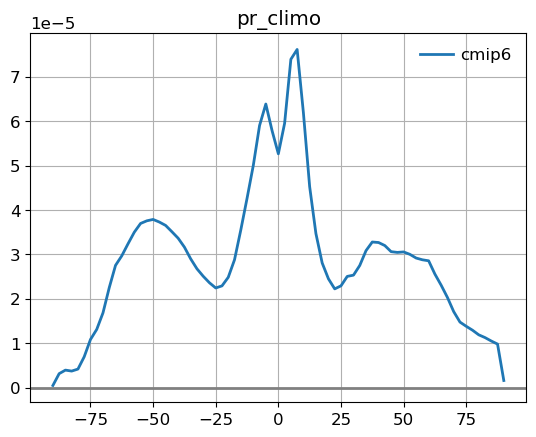

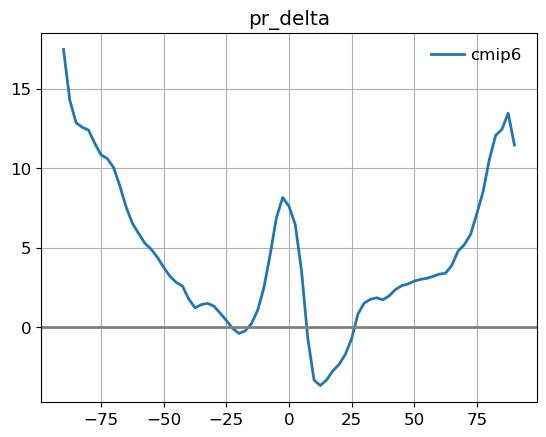

In [12]:
bon = xr.open_mfdataset(fpath+'bonan_allmods.nc')

plt.subplots()
fbk = 'pr_climo'
Pavg = bon.mean('modripf')[fbk].mean('time')
plt.title(fbk)
plt.plot(toa.lat,Pavg.mean(('lon')),ls=LS,label=era)
# plt.ylim(-5,5)
plt.axhline(y=0,color='gray')
plt.grid()
plt.legend()

plt.subplots()
fbk = 'pr_delta'
dP = bon.mean('modripf')[fbk].mean('time')
plt.title(fbk)
data = 100*dP.mean(('lon'))/Pavg.mean(('lon'))
plt.plot(toa.lat,data,ls=LS,label=era)
# plt.ylim(-5,5)
plt.axhline(y=0,color='gray')
plt.grid()
plt.legend()


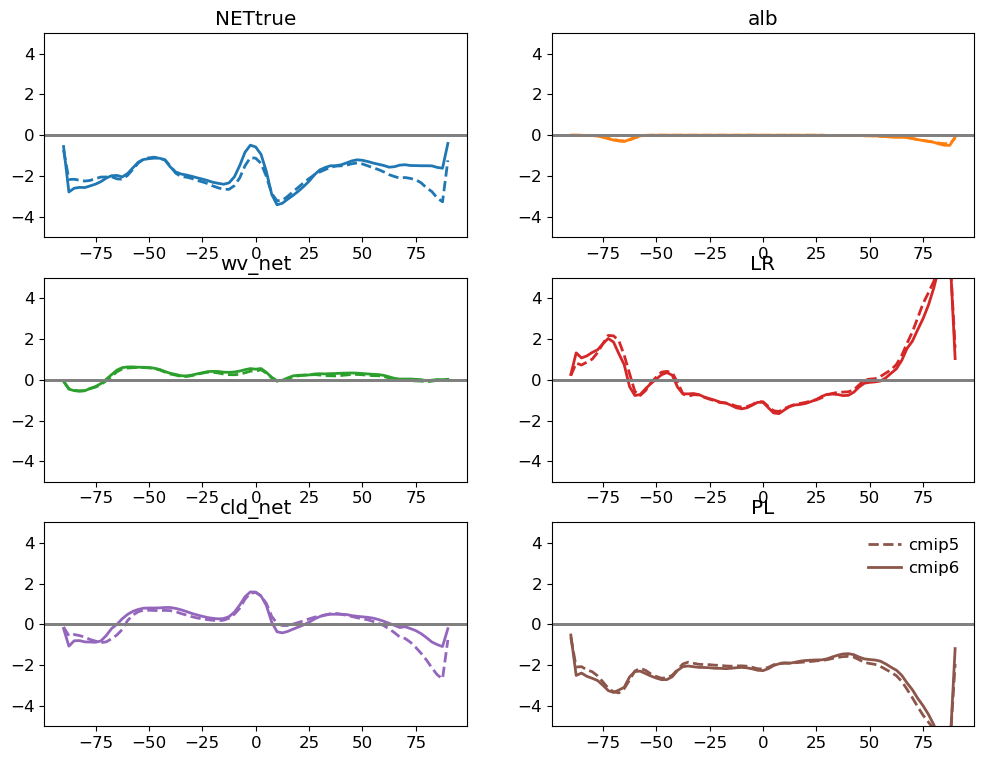

In [3]:
plt.figure(figsize=(12,9))
for era in ['cmip5','cmip6']:
    if era=='cmip5':
        fpath = '/p/user_pub/climate_work/zelinka1/cmip5/abrupt4xCO2/'
        LS='--'
    else:
        fpath = '/p/user_pub/climate_work/zelinka1/cmip6/abrupt-4xCO2/'
        LS='-'
    toa = xr.open_mfdataset(fpath+'toa_fbks_allmods.nc')
    sfc = xr.open_mfdataset(fpath+'sfc_fbks_allmods.nc')
    for f,fbk in enumerate(['NETtrue','alb','wv_net','LR','cld_net','PL']):
        Tavg = toa.mean('modripf')[fbk].mean('time')
        Savg = sfc.mean('modripf')[fbk].mean('time')
        Aavg = Tavg-Savg
        plt.subplot(3,2,f+1)
        plt.title(fbk)
    #     plt.plot(Tavg.mean(('lon')),label='TOA')
        plt.plot(toa.lat,Aavg.mean(('lon')),ls=LS,color='C'+str(f),label=era)
    #     plt.plot(Savg.mean(('lon')),label='SFC')
    #     plt.legend()
        plt.ylim(-5,5)
        plt.axhline(y=0,color='gray')
        plt.grid()
plt.legend()

## Compare these new calcuations with those in 2020 GRL paper:

In [42]:
import json
with open('/home/zelinka1/scripts/cmip56_forcing_feedback_ecs.json') as json_file:
    OLD = json.load(json_file)
OLD['CMIP5']['ACCESS1-0']['r1i1p1'].keys()
oldvars = ['ALB','CLD','ERR', 'LR', 'LR*', 'LWCLD', 'NET', 'PL', 'PL*', 'RH', 'SWCLD', 'WV']
newvars = ['alb','cld_net','resid_net','LR','HS_LR','cld_lw','NETtrue','PL','HS_PL','HS_RH','cld_sw','wv_net']
alias = dict(zip(oldvars,newvars))
alias

{'ALB': 'alb',
 'CLD': 'cld_net',
 'ERR': 'resid_net',
 'LR': 'LR',
 'LR*': 'HS_LR',
 'LWCLD': 'cld_lw',
 'NET': 'NETtrue',
 'PL': 'PL',
 'PL*': 'HS_PL',
 'RH': 'HS_RH',
 'SWCLD': 'cld_sw',
 'WV': 'wv_net'}

CMIP5
no new data for CSIRO-Mk3-6-0.r1i1p1
no new data for FGOALS-g2.r1i1p1
no new data for MPI-ESM-LR.r1i1p1
no new data for MPI-ESM-MR.r1i1p1
no new data for MPI-ESM-P.r1i1p1
no new data for NorESM1-ME.r1i1p1
CMIP6
no new data for BCC-ESM1.r1i1p1f1
no new data for CAMS-CSM1-0.r1i1p1f1
no new data for CAMS-CSM1-0.r2i1p1f1
no new data for EC-Earth3-AerChem.r1i1p1f1
no new data for GFDL-ESM4.r1i1p1f1
no new data for IPSL-CM5A2-INCA.r1i1p1f1
no new data for NESM3.r1i1p1f1
no new data for NorCPM1.r1i1p1f1
no new data for NorESM2-LM.r1i1p1f1
no new data for NorESM2-MM.r1i1p1f1
no new data for TaiESM1.r1i1p1f1


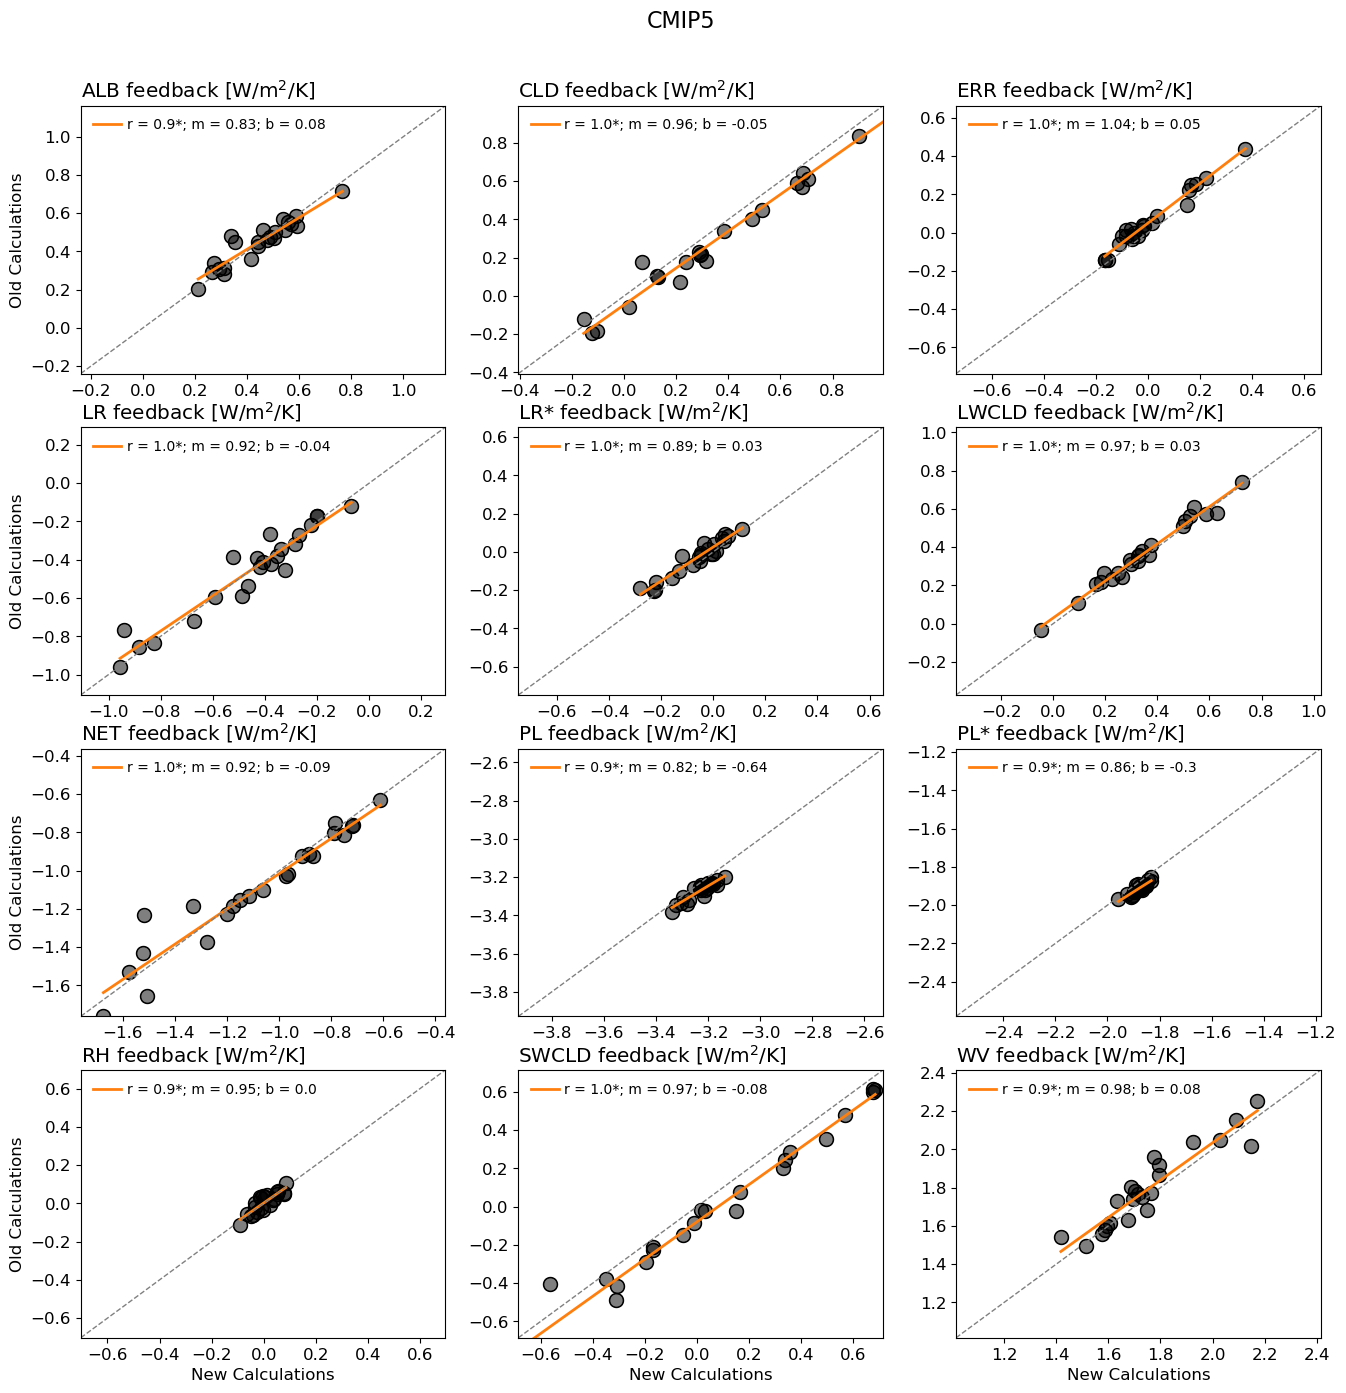

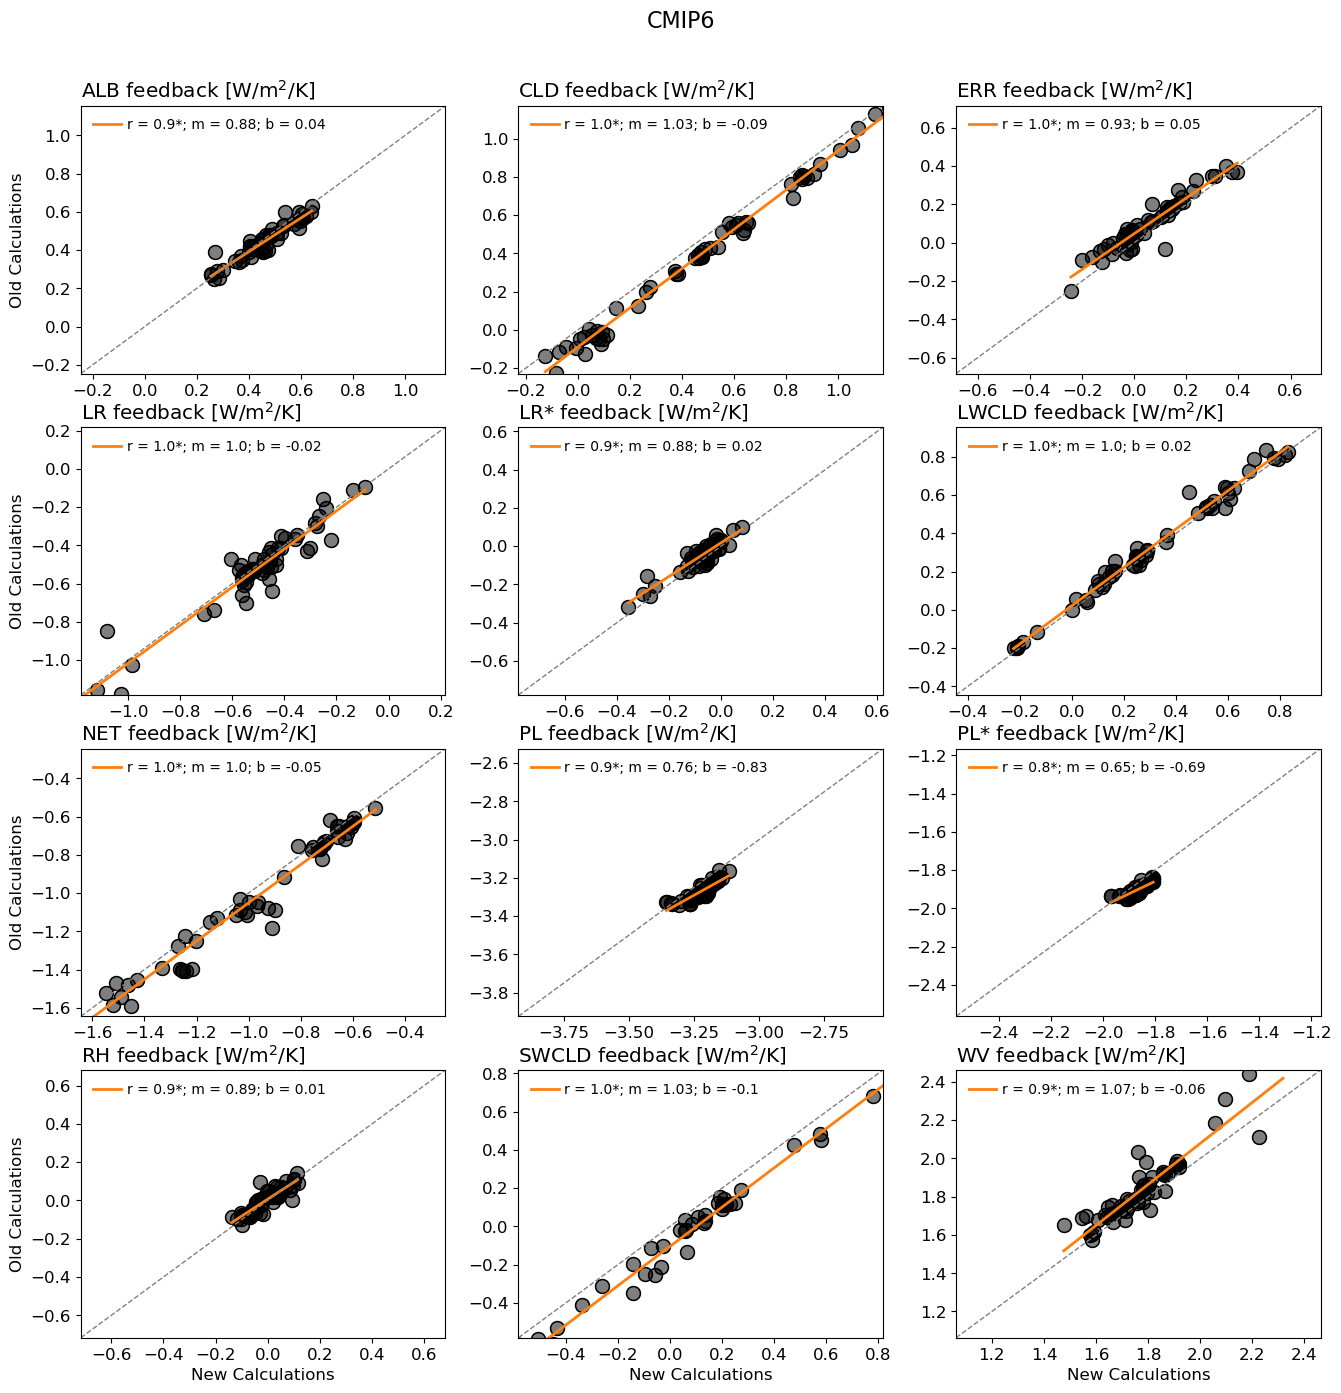

In [49]:
# Loop over these models/variants and do kernel calculation:
name = 'toa_fbks'
eras=['CMIP5','CMIP6']
for era in eras:
    print(era)
    if era=='CMIP5':
        exp = 'abrupt4xCO2'
        fpath = '/p/user_pub/climate_work/zelinka1/cmip5/abrupt4xCO2/'
    else:
        exp = 'abrupt-4xCO2'
        fpath = '/p/user_pub/climate_work/zelinka1/cmip6/abrupt-4xCO2/'

    cnt=0
    plt.figure(figsize=(16,16))
    plt.suptitle(era,y=0.94,fontsize=16)
    for oldvar in list(alias.keys()):
        cnt+=1
        newvar = alias[oldvar]
        new=[]
        old=[]
        names=[]
        models = list(OLD[era].keys())
        for mod in models:
            ripfs = list(OLD[era][mod].keys())
            for ripf in ripfs:
                gg=glob.glob(fpath+name+'_'+mod+'.'+ripf+'.nc')
                if len(gg)==0:
                    if cnt==1:
                        print('no new data for '+mod+'.'+ripf)
                    continue
                ds0 = xr.open_mfdataset(gg[0])
                old.append(OLD[era][mod][ripf][oldvar])
                new.append(ds0.spatial.average(newvar).mean('time')[newvar].values)
            names.append(mod+'.'+ripf)

        x,y = new,old
        plt.subplot(4,3,cnt)
        color='k'
        plt.plot(x,y,'o',mfc=color,mec='k',ms=10,alpha=0.5)
        plt.plot(x,y,'o',mfc='None',mec='k',ms=10)
        xmin = np.min(y) - 0.1
        xmax = np.max(y) + 0.1
        dummy=np.linspace(xmin,xmax,11)
        slope, intercept, r, p, se = linregress(x,y)
        dummy = np.linspace(np.nanmin(x),np.nanmax(x),100)
        asterisk=''
        if p<0.05:
            asterisk='*'
        LABEL = 'r = '+str(np.round(r,1))+asterisk+'; m = '+str(np.round(slope,2))+'; b = '+str(np.round(intercept,2))
        plt.plot(dummy,slope*dummy+intercept,label=LABEL,lw=2,color='C1')
        plt.legend(fontsize=10)
        if cnt>9:
            plt.xlabel('New Calculations')
        if cnt==1 or cnt==4 or cnt==7 or cnt==10:
            plt.ylabel('Old Calculations')
        plt.title(oldvar+' feedback [W/m$^2$/K]',loc='left') 
        xm = np.median(x)
        dummy=np.linspace(xm-0.7,xm+0.7,11)
        plt.plot(dummy,dummy,lw=1,ls='--',color='gray')
        plt.xlim(xm-0.7,xm+0.7)
        plt.ylim(xm-0.7,xm+0.7)
    

In [ ]:
lo=20
plt.subplots()
plt.title('Warming or Kernels [0N, '+str(lo)+'E]',loc='left')
plt.plot(DELTA['ta']['ta'].sel(lat=0,method='nearest').sel(lon=lo,method='nearest').mean('time'),PLEV/100,'o-',color='k',label='$\\Delta$ Ta')
plt.axvline(x=DELTA['ts']['ts'].sel(lat=0,method='nearest').sel(lon=lo,method='nearest').mean('time'),color='gray',label='$\\Delta$ Ts')
plt.plot(SFC_KERN['ta_all'].sel(lat=0,method='nearest').sel(lon=lo,method='nearest').mean('time'),PLEV/100,'o-',color='C1',label='$\\partial$R/$\\partial$Ta')
plt.axvline(x=-SFC_KERN['ts_all'].sel(lat=0,method='nearest').sel(lon=10,method='nearest').mean('time'),color='C1',alpha=0.5,label='$-\\partial$R/$\\partial$Ts')
plt.ylim(1025,825)
plt.legend()
plt.ylabel('pressure [hPa]')
plt.xlabel('K or W/m$^2$/K')

plt.subplots()
plt.title('Warming or Kernels [0N, '+str(lo)+'E]',loc='left')
# plt.plot(1000*DATA['hus'][0]['hus'].sel(lat=0,method='nearest').sel(lon=lo,method='nearest').mean('time'),PLEV/100,'o-',color='k',label='hus0')
# plt.plot(1000*DATA['hus'][1]['hus'].sel(lat=0,method='nearest').sel(lon=lo,method='nearest').mean('time'),PLEV/100,'o--',color='C0',label='hus1')
plt.plot(1000*DELTA['hus']['hus'].sel(lat=0,method='nearest').sel(lon=lo,method='nearest').mean('time'),PLEV/100,'o-',color='k',label='$\\Delta$ hus')
plt.plot(SFC_KERN['wv_lw_all'].sel(lat=0,method='nearest').sel(lon=lo,method='nearest').mean('time'),PLEV/100,'o-',color='C1',label='$\\partial$R/$\\partial$Q')
plt.ylim(1025,825)
plt.legend()
plt.ylabel('pressure [hPa]')
plt.xlabel('g/kg or W/m$^2$/K')

In [ ]:
    
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
var='sum_lw_dn'
one = SFC_FBK[var].mean('time')
plt.pcolor(SFC_FBK.lon,SFC_FBK.lat,one,vmin=-12,vmax=12,cmap='RdBu_r')
GL=np.round(SFC_FBK.spatial.average(var).mean('time')[var].values,2)
plt.title('a) '+var+' ['+str(GL)+']',loc='left')
plt.plot(coastlon, coastlat, color = 'k', linewidth = 0.5)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 360)

plt.subplot(2,3,2)
var='rlds'
DS = DELTA[var]
two = DS[var].mean('time')
plt.pcolor(DS.lon,DS.lat,two,vmin=-12,vmax=12,cmap='RdBu_r')
# GL=np.round(DS.spatial.average(var).mean('time')[var].values,2)
plt.title('b) '+var,loc='left')
plt.plot(coastlon, coastlat, color = 'k', linewidth = 0.5)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 360)

plt.subplot(2,3,3)
plt.pcolor(DS.lon,DS.lat,(one-two),vmin=-12,vmax=12,cmap='RdBu_r')
plt.colorbar()
# GL=np.round(DS.spatial.average(var).mean('time')[var].values,2)
plt.title('a-b',loc='left')
plt.plot(coastlon, coastlat, color = 'k', linewidth = 0.5)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 360)

plt.subplot(2,3,4)
var='sum_lw_up'
one = SFC_FBK[var].mean('time')
plt.pcolor(SFC_FBK.lon,SFC_FBK.lat,one,vmin=-12,vmax=12,cmap='RdBu_r')
GL=np.round(SFC_FBK.spatial.average(var).mean('time')[var].values,2)
plt.title('d) '+var+' ['+str(GL)+']',loc='left')
plt.plot(coastlon, coastlat, color = 'k', linewidth = 0.5)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 360)

plt.subplot(2,3,5)
var='rlus'
DS = DELTA[var]
two = -DS[var].mean('time')
plt.pcolor(DS.lon,DS.lat,two,vmin=-12,vmax=12,cmap='RdBu_r')
# GL=np.round(DS.spatial.average(var).mean('time')[var].values,2)
plt.title('e) '+var,loc='left')
plt.plot(coastlon, coastlat, color = 'k', linewidth = 0.5)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 360)

plt.subplot(2,3,6)
plt.pcolor(DS.lon,DS.lat,(one-two),vmin=-12,vmax=12,cmap='RdBu_r')
plt.colorbar()
# GL=np.round(DS.spatial.average(var).mean('time')[var].values,2)
plt.title('d-e',loc='left')
plt.plot(coastlon, coastlat, color = 'k', linewidth = 0.5)
plt.xticks([])
plt.yticks([])
plt.xlim(0, 360)
    
